# PennyLane Gang VQE for BeH2 (in Qiskit!)

## Imports

In [1]:
!pip install qiskit qiskit-nature[pyscf] pylatexenc -U --quiet

In [2]:
!pip install qiskit_ibm_runtime -U --quiet

In [3]:
!pip show qiskit_nature 
!pip show pyscf

Name: qiskit-nature
Version: 0.5.2
Summary: Qiskit Nature: A library of quantum computing chemistry/physics experiments
Home-page: https://github.com/Qiskit/qiskit-nature
Author: Qiskit Nature Development Team
Author-email: hello@qiskit.org
License: Apache-2.0
Location: /usr/local/lib/python3.8/dist-packages
Requires: h5py, numpy, psutil, qiskit-terra, rustworkx, scikit-learn, scipy, setuptools, typing-extensions
Required-by: 
Name: pyscf
Version: 2.1.1
Summary: PySCF: Python-based Simulations of Chemistry Framework
Home-page: http://www.pyscf.org
Author: Qiming Sun
Author-email: osirpt.sun@gmail.com
License: Apache License 2.0
Location: /usr/local/lib/python3.8/dist-packages
Requires: h5py, numpy, scipy
Required-by: 


In [4]:
# Import necessary libraries and packages
import math
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from qiskit import Aer, IBMQ, QuantumCircuit
from qiskit.primitives import Estimator, BackendEstimator
from qiskit.providers.fake_provider import FakeManilaV2, FakeAthensV2, FakeAthens, FakeLagos
from qiskit.providers.aer import StatevectorSimulator
from qiskit.utils import QuantumInstance, algorithm_globals

from qiskit.tools.jupyter import *
from qiskit.visualization import *

# Import Qiskit libraries for VQE
from qiskit.algorithms import MinimumEigensolver, VQEResult, MinimumEigensolverResult, VQE
from qiskit.algorithms.optimizers import SLSQP, SPSA, L_BFGS_B, GradientDescent
from qiskit.circuit.library import TwoLocal, EfficientSU2

# Import Qiskit Nature libraries
from qiskit_nature.algorithms import GroundStateEigensolver, VQEUCCFactory
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.circuit.library import UCC, UCCSD
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import BravyiKitaevMapper, JordanWignerMapper, ParityMapper
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer, FreezeCoreTransformer

# from qiskit_ibm_runtime import Estimator, Session, QiskitRuntimeService, Options

from qiskit_aer.noise import NoiseModel
from qiskit_aer.primitives import Estimator as Aer_Estimator

from IPython.display import clear_output

# Prototype-zne
!pip install prototype-zne --quiet

from qiskit_nature.settings import settings

settings.dict_aux_operators = True

## Construct Problem, Molecule, and Ideal

In [27]:
def construct_problem(geometry, charge, multiplicity, basis, num_electrons, num_molecular_orbitals):

    molecule = Molecule(geometry=geometry,
                            charge=charge, 
                            multiplicity=multiplicity) # This is an example for LiH with bond distance of 2.5 Angstroms, neutral charge, spin multiplicity of 1
    driver = ElectronicStructureMoleculeDriver(molecule, basis=basis, driver_type=ElectronicStructureDriverType.PYSCF) # This is an example of using STO-3G basis set, and performing preliminary Quantum Chemistry calculation using PySCF

    # Run the preliminary quantum chemistry calculation
    properties = driver.run()

    # Freezing lowest electron orbitals and removing inactive orbitals (found experimentally based on Kandala et al.)
    freezeCoreTransformer = FreezeCoreTransformer(True,remove_orbitals=[3,4])

    # Now you can get the reduced electronic structure problem
    problem_reduced = ElectronicStructureProblem(driver, transformers=[freezeCoreTransformer])

    # Set the mapper to qubits
    parity_mapper = ParityMapper() # This is the example of parity mapping

    # Set the qubit converter with two qubit reduction to reduce the computational cost 
    parity_converter = QubitConverter(parity_mapper, two_qubit_reduction=True)

    return problem_reduced, parity_converter

def construct_ideal(problem, converter):

    # The second quantized Hamiltonian of the reduce problem
    second_q_ops_reduced = problem.second_q_ops()

    # Compute the Hamitonian in qubit form
    qubit_op_parity = converter.convert(second_q_ops_reduced.get('ElectronicEnergy'), num_particles=problem.num_particles)
   
    # Get reference solution
    vqe_factory = VQEUCCFactory(quantum_instance=Aer.get_backend("aer_simulator_statevector"),optimizer=SLSQP(maxiter=50),
                                ansatz=UCC(excitations='sd')
                                ) # This is an example of UCC"SD" ansatz
    solver = GroundStateEigensolver(converter, vqe_factory)    
    vqe_ideal_solution = solver.solve(problem).total_energies[0].real 

    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    exact_solution = calc.solve(problem).total_energies[0].real   
    
    ansatz=vqe_factory.ansatz
    return ansatz, qubit_op_parity, exact_solution, vqe_ideal_solution

In [6]:
import matplotlib.pyplot as plt

def plot_graph(energy, real_solution, molecule, color="tab:blue"):
    
    plt.rcParams["font.size"] = 14

    # plot loss and reference value
    plt.figure(figsize=(12, 6), facecolor='white')
    plt.plot(energy, label="Estimator VQE {}".format(molecule),color = color)
    plt.axhline(y=real_solution.real, color="tab:red", ls="--", label="Target")

    plt.legend(loc="best")
    plt.xlabel("Iteration")
    plt.ylabel("Energy [H]")
    plt.title("VQE energy")
    plt.show()

In [7]:
# Constructing BeH2
def get_molecule(distance):
  return [["Be", [ 0.0,    0.0,    0.0]], 
        ["H", [ 0.0,    0.0,   -distance]],
        ["H", [ 0.0,    0.0,   distance]]]

## Hardware efficient ansatz

In [8]:
from qiskit.circuit import ParameterVector

def create_ansatz(depth):
  # number of qubits
  n_qubit = 6

  # number of layers
  custom_ansatz = QuantumCircuit(n_qubit)
  theta = ParameterVector('θ', n_qubit*depth*4)# rx +6)

  for d in range(depth):
    for i in range(n_qubit):
      custom_ansatz.ry(theta[2*i+2*n_qubit*d], i)
      custom_ansatz.rz(theta[2*i+1+2*n_qubit*d], i)
    custom_ansatz.barrier()
    for i in range(n_qubit//2):
      custom_ansatz.cx(2*i, 2*i+1)
    for i in range(n_qubit//2-1):
      custom_ansatz.cx(2*i+1, 2*i+2)
    custom_ansatz.cx(5, 0)
    custom_ansatz.barrier()
    for i in range(n_qubit):
      custom_ansatz.ry(theta[2*i+2*n_qubit*depth], i)
      custom_ansatz.rz(theta[2*i+1+2*n_qubit*depth], i)
      #if d == 0:
      #  custom_ansatz.rx(theta[2*i+1+2*n_qubit*depth], i)

  print("Circuit depth:", custom_ansatz.depth())
  custom_ansatz.draw('mpl')
  return custom_ansatz

## Custom VQE Class



In [9]:
# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):

    def __init__(self, estimator, circuit, optimizer, problem=None, callback=None, aux_operators=None):#, initial_point=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._problem = problem
        self._callback = callback
        #self._initial_point = initial_point
        self.params_history = []
        
    def compute_minimum_eigenvalue(self, operators, initial_point=None):

        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            x = list(x)
            job = self._estimator.run([self._circuit], [operators], [x])
            #display("job: {}".format(job.job_id()))
            # ---
            self.params_history.append(x)
            # ---
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            
            sol = MinimumEigensolverResult()
            sol.eigenvalue = value
            sol = self._problem.interpret(sol).total_energies[0]

            # Save result information using callback function
            if self._callback is not None:
                self._callback(np.real(sol), len(self.params_history))
            return np.real(sol)

        # Select an initial point for the ansatzs' parameters
        #x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        #x0 = [np.pi/4] * self._circuit.num_parameters
        
        if initial_point is None:
            initial_point = [np.pi/4] * self._circuit.num_parameters # np.random.rand(self._circuit.num_parameters)
        
        #print(self._initial_point)
        # TODO: Initial point as parameter
        res = self._optimizer.minimize(objective, x0=initial_point)#, bounds=[-18.5,-16])#self._initial_point)

        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_value = res.fun
        result.optimal_parameters = res.x

        return result, self.params_history

## Custom VQE Executor

In [23]:
%%time
def custom_vqe_sim(depth, problem, ops, exact_solution, noisy=False, optimizer=None, backend=FakeLagos(), options=None):
  # VQE for BeH2
  custom_ansatz = create_ansatz(depth)

  algorithm_globals.random_seed = 1024
  # For H2
  if noisy:
    estimator = BackendEstimator(backend=backend, options=options)
    maxiter = 150
  else:
    estimator = Aer_Estimator([custom_ansatz], [ops.primitive], backend_options={'method':'statevector'}, run_options={'shots':None}, approximation=True)
    maxiter = 20000

  intermediate_info = []

  # Define a simple callback function returning interpreted eigenvalue
  def callback(value, iter_num):
          # Overwrites the same line when printing
          display("{}: Energy = {}".format(iter_num, value))
          clear_output(wait=True)
          intermediate_info.append(value)

  # Choose optimizer
  if not optimizer:
    optimizer = L_BFGS_B(maxfun=maxiter, ftol=2.220446049250313e-15)
  elif optimizer.lower() == 'spsa':
    optimizer = SPSA(maxiter=maxiter)
  elif optimizer.lower() == 'slsqp':
    optimizer = SLSQP(maxiter=maxiter,ftol=2.220446049250313e-15)
  elif optimizer.lower() == 'l_bfgs_b':
    optimizer = L_BFGS_B(maxfun=maxiter, ftol=2.220446049250313e-15)

  initial_point = np.ones(custom_ansatz.num_parameters) * np.pi/4

  # Setup VQE algorithm
  custom_vqe = CustomVQE(estimator, custom_ansatz, optimizer, problem, callback=callback)

  # Run the custom VQE function and monitor execution time
  result, params_history = custom_vqe.compute_minimum_eigenvalue(ops.primitive, initial_point=initial_point)

  # Plot Graph BeH2
  diff = np.abs(intermediate_info[-1].real-exact_solution)
  print("Relative error:", np.round(diff/exact_solution*100,4), "%", " = ", diff, "Ha")
  plot_graph(intermediate_info, exact_solution, "BeH2")

  print("Optimal parameters:", result.optimal_parameters)
  return intermediate_info[-1], diff

CPU times: user 1.54 ms, sys: 0 ns, total: 1.54 ms
Wall time: 1.89 ms


## Bond Distances

Relative error: -0.0494 %  =  0.007664794807226372 Ha


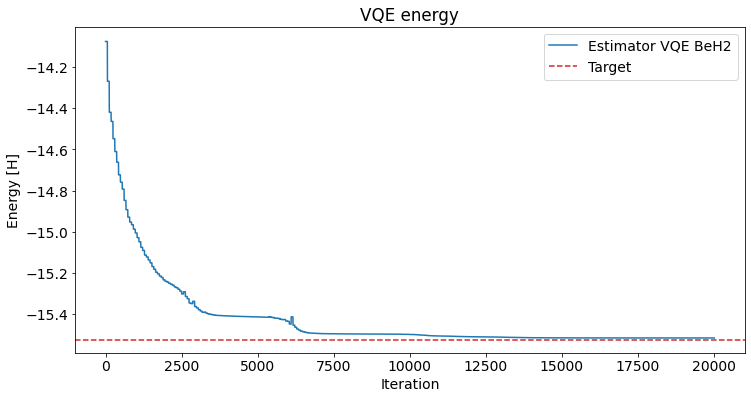

Optimal parameters: [-1.81342428e-01  1.48843064e+00  1.57463593e+00  1.60456838e+00
  1.43435919e+00 -8.94635383e-03  1.04933543e+00  1.56954814e+00
 -1.57871713e+00  1.82806048e+00 -5.46620834e-03  7.28123788e-01
 -1.32624702e-01  1.67615493e+00  1.56922526e+00  1.55201944e+00
  1.58099387e+00 -1.49657368e-01 -2.34236409e-02 -1.08237978e+00
 -1.20546928e-02  1.67003844e+00 -1.32139014e-01  3.79393688e-02
  1.58499761e+00  1.68998700e+00  1.49803977e+00  1.43764736e-01
  2.71517451e-01 -5.32172676e-01 -1.58340789e-03 -3.40652315e-01
  1.11901369e-01  1.67770211e+00  7.95287128e-01  7.47891959e-04
 -3.08765288e-03  3.28013262e+00 -1.55180949e+00 -1.36262185e-02
  3.69337185e-02 -1.96496439e+00 -2.62139791e-02  4.65261500e-01
  1.65844910e-02  1.67320764e+00  1.56277065e+00 -5.42951558e-03
 -9.37094555e-03  1.44363122e+00 -7.29906593e-03  1.80142656e-03
  1.59922851e+00  1.96408966e+00  1.57433758e+00  1.10588969e+00
  1.58588385e+00 -1.04728104e-01  1.57855355e+00  1.53941513e+00]


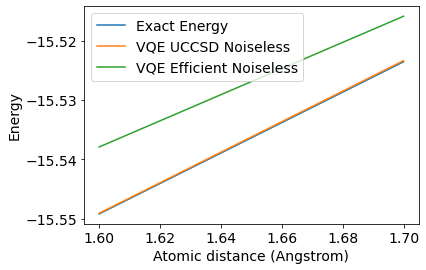

In [26]:
distances = [1.6, 1.7] # np.linspace(0.5, 2.0, 16)
expected_energies = []
uccsd_energies = []
vqe_efficient_energies = []

for dist in distances:
  problem, converter = construct_problem(geometry=get_molecule(dist), charge=0, multiplicity=1, basis="sto3g", num_electrons=6, num_molecular_orbitals=7)

  _, ops, exact_solution, vqe_ideal_solution = construct_ideal(problem, converter)

  vqe_efficient_solution, vqe_efficient_diff = custom_vqe_sim(4, problem, ops, exact_solution)

  expected_energies.append(exact_solution)
  uccsd_energies.append(vqe_ideal_solution)
  vqe_efficient_energies.append(vqe_efficient_solution)

plt.plot(distances, expected_energies, label="Exact Energy")
plt.plot(distances, uccsd_energies, label="VQE UCCSD Noiseless")
plt.plot(distances, vqe_efficient_energies, label="VQE Efficient Noiseless")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()